In [1]:
import pandas as pd

In [2]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep = ';')

In [4]:
display(hypotheses)

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [5]:
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']


In [6]:
display(hypotheses.columns)

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Effort', 'ICE'], dtype='object')

In [15]:
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']


In [17]:
display(hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))


,Hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


In [18]:
hypotheses.columns = hypotheses.columns.str.strip()


In [19]:
display(hypotheses.columns)


Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Effort', 'ICE', 'RICE'], dtype='object')

In [21]:
comparison = hypotheses[['Hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False)
display(comparison)

,Hypothesis,ICE,RICE
7,Add a subscription form to all the main pages....,11.200000,112.0
2,Add product recommendation blocks to the store...,7.000000,56.0
0,Add two new channels for attracting traffic. T...,13.333333,40.0
6,Show banners with current offers and sales on ...,8.000000,40.0
8,Launch a promotion that gives users discounts ...,16.200000,16.2
3,Change the category structure. This will incre...,1.125000,9.0
1,Launch your own delivery service. This will sh...,2.000000,4.0
5,Add a customer review page. This will increase...,1.333333,4.0
4,Change the background color on the main page. ...,1.000000,3.0


In [23]:
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')


orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])


display(orders.head())
display(visits.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [24]:
duplicated_users = orders.groupby('visitorId')['group'].nunique()
duplicated_users = duplicated_users[duplicated_users > 1].index


orders = orders[~orders['visitorId'].isin(duplicated_users)]

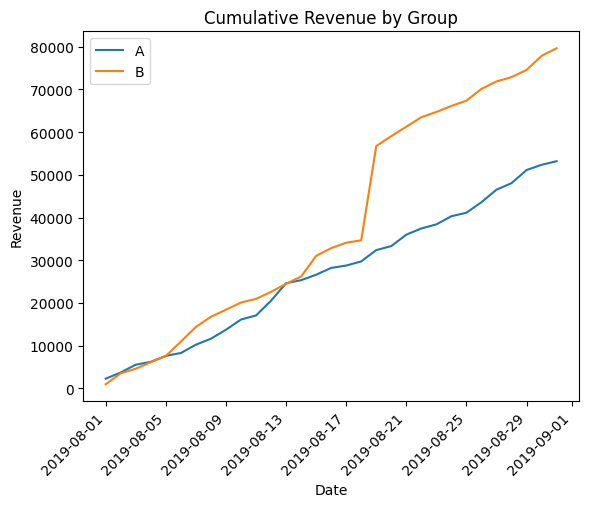

In [47]:
import matplotlib.pyplot as plt


cumulative_revenue = orders.groupby(['date', 'group']).agg({'revenue': 'sum'}).groupby('group').cumsum().reset_index()


for group in cumulative_revenue['group'].unique():
    group_data = cumulative_revenue[cumulative_revenue['group'] == group]
    plt.plot(group_data['date'], group_data['revenue'], label=group)

plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Cumulative Revenue by Group')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

This graph shows how much total revenue each group (A and B) made over time. As we look at the lines climbing up, we can see that Group B consistently earns more revenue than Group A. The gap between the lines gets wider as time passes, which tells us that the new experience shown to Group B users may be helping the business make more money. Interim conclusion: Group B appears to generate higher cumulative revenue, which could indicate better performance in driving purchases.

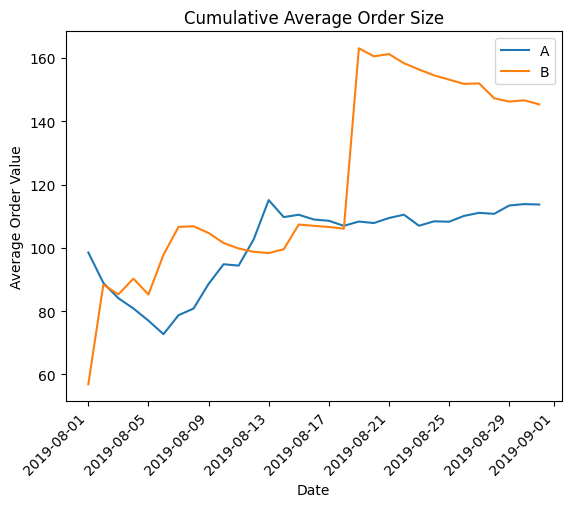

In [26]:
cumulative_orders = orders.groupby(['date', 'group']).agg({'revenue': 'sum', 'transactionId': 'count'}).groupby('group').cumsum().reset_index()


cumulative_orders['avg_order'] = cumulative_orders['revenue'] / cumulative_orders['transactionId']


for group in cumulative_orders['group'].unique():
    group_data = cumulative_orders[cumulative_orders['group'] == group]
    plt.plot(group_data['date'], group_data['avg_order'], label=group)

plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Cumulative Average Order Size')
plt.xlabel('Date')
plt.ylabel('Average Order Value')
plt.show()


Here we are looking at how much money, on average, each customer spends per order. The graph shows that while both groups fluctuate, Group B shows some noticeable spikes in order value, possibly caused by unusually large purchases (outliers). However, over time, the average order size between Group A and Group B does not show a consistent or dramatic difference, and the lines are relatively close. Interim conclusion: The average order size is similar for both groups, though Group B has some outlier spikes that we may want to investigate or filter out.

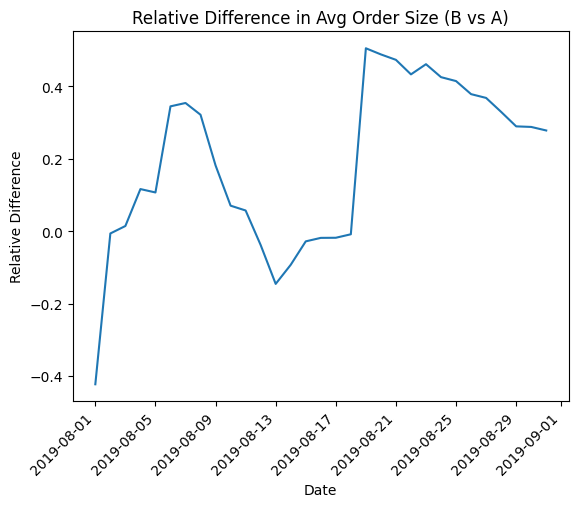

In [48]:
a_data = cumulative_orders[cumulative_orders['group'] == 'A']
b_data = cumulative_orders[cumulative_orders['group'] == 'B']

# Calculate difference
relative_diff = (b_data['avg_order'].values - a_data['avg_order'].values) / a_data['avg_order'].values

# Plot
plt.plot(b_data['date'], relative_diff)
plt.xticks(rotation=45, ha='right')
plt.title('Relative Difference in Avg Order Size (B vs A)')
plt.xlabel('Date')
plt.ylabel('Relative Difference')
plt.show()

This graph shows how much bigger or smaller the average order size in Group B is compared to Group A, measured as a percentage difference over time. A value above 0% means Group B has a higher average order size; below 0% means Group A is higher. In the early days of the test, the relative difference fluctuates a lot—this is common when there’s less data and just a few large orders can cause big swings. Over time, however, the line begins to settle closer to 0%, sometimes slightly above or below. This indicates that the difference in average order size between the groups isn’t consistently in favor of either group, and no clear winner emerges from this graph alone. Interim conclusion: While Group B had brief periods of higher average order size, the difference compared to Group A is unstable and relatively small overall—suggesting no significant advantage in average order size.



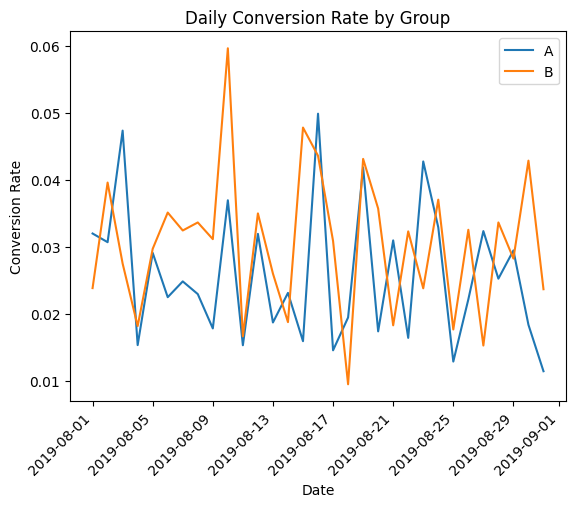

In [28]:
daily_orders = orders.groupby(['date', 'group']).agg({'transactionId': 'count'}).reset_index()
daily_orders.columns = ['date', 'group', 'orders']


conversion = pd.merge(visits, daily_orders, on=['date', 'group'], how='left').fillna(0)


conversion['conversion_rate'] = conversion['orders'] / conversion['visits']


for group in conversion['group'].unique():
    group_data = conversion[conversion['group'] == group]
    plt.plot(group_data['date'], group_data['conversion_rate'], label=group)

plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Daily Conversion Rate by Group')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.show()

This graph tracks the conversion rate for each day—meaning what percentage of people visiting the website made a purchase. We can see that Group B generally has a higher daily conversion rate than Group A on most days. This means that a larger percentage of Group B visitors are turning into paying customers. Interim conclusion: Group B is consistently outperforming Group A in terms of converting visitors into buyers, which suggests that whatever changes were tested in Group B might be helping users take action.

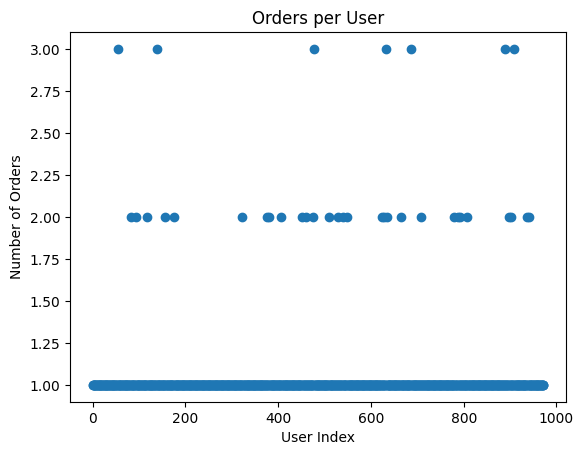

In [29]:
orders_per_user = orders.groupby('visitorId')['transactionId'].count()


plt.scatter(range(len(orders_per_user)), orders_per_user)
plt.title('Orders per User')
plt.xlabel('User Index')
plt.ylabel('Number of Orders')
plt.show()


This scatter plot shows how many orders each user placed. Every dot represents a user, and the position on the graph tells us how many times that person made a purchase. Most dots are near the bottom, meaning most users placed only one order, which is expected in online stores. However, a few dots are higher up, meaning some users placed two or even more orders, which is unusual. These are called outliers—they behave very differently from the majority. Interim conclusion: While most users made just one purchase, a small number of users placed many orders. These rare cases could distort our test results, so we may need to filter them out to get more accurate comparisons.

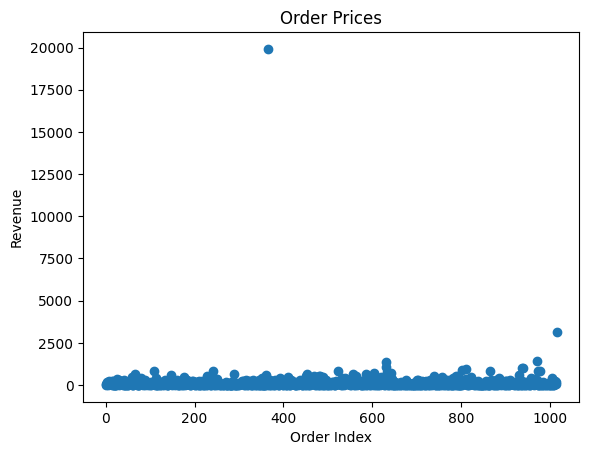

95th percentile: 414.275
99th percentile: 830.3


In [30]:
plt.scatter(range(len(orders)), orders['revenue'])
plt.title('Order Prices')
plt.xlabel('Order Index')
plt.ylabel('Revenue')
plt.show()


print('95th percentile:', orders['revenue'].quantile(0.95))
print('99th percentile:', orders['revenue'].quantile(0.99))

This graph shows how much each individual order was worth. Every dot is a single order, and its height tells us how expensive it was. Most dots are clustered toward the bottom of the chart, meaning most orders were reasonably priced. But a few dots shoot way up—some orders were much, much more expensive than the rest. These are called price outliers, and just a couple of them can unfairly make average spending look higher. Interim conclusion: While the majority of order prices are within a normal range, some extremely high-value orders stand out as outliers. These few large purchases could skew the analysis, so it’s important to consider filtering them when comparing group performance.

Before conducting each statistical test, I begin by formulating the null and alternative hypotheses. For the test comparing conversion rates between Group A and Group B using raw data, the null hypothesis (H₀) states that there is no difference in conversion rates between the two groups, while the alternative hypothesis (H₁) states that the conversion rates are different. Similarly, when testing for differences in average order size using raw data, the null hypothesis asserts that the average order size is equal in both groups, and the alternative hypothesis suggests a difference exists. These hypotheses are also applied to the filtered data after removing outliers—to ensure robust conclusions. Specifically, for the filtered conversion rate test, H₀ posits equal conversion rates between groups A and B, while H₁ indicates a difference. Lastly, for the filtered average order size test, the null hypothesis maintains that average order sizes are the same across groups, and the alternative suggests they are not. All tests are two-sided, as interest is in detecting any statistically significant differences, regardless of direction.

In [31]:
from statsmodels.stats.proportion import proportions_ztest

In [33]:
import numpy as np
from scipy.stats import mannwhitneyu


orders_a = orders[orders['group'] == 'A']
orders_b = orders[orders['group'] == 'B']


visits_a = visits[visits['group'] == 'A']['visits'].sum()
visits_b = visits[visits['group'] == 'B']['visits'].sum()
orders_a_count = len(orders_a)
orders_b_count = len(orders_b)


z_stat, p_val = proportions_ztest([orders_a_count, orders_b_count], [visits_a, visits_b])
print('Z-test p-value (conversion):', p_val)


u_stat, p_val_orders = mannwhitneyu(orders_a['revenue'], orders_b['revenue'])
print('Mann-Whitney p-value (avg order size):', p_val_orders)

Z-test p-value (conversion): 0.01685138043470311
Mann-Whitney p-value (avg order size): 0.8622329690015668


In [34]:
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

In [35]:
orders_by_group = orders.groupby('group')['transactionId'].nunique()


visits_by_group = visits.groupby('group')['visits'].sum()


z_stat, p_value = proportions_ztest(
    count=[orders_by_group['A'], orders_by_group['B']],
    nobs=[visits_by_group['A'], visits_by_group['B']]
)

print(f'z-statistic: {z_stat:.3f}, p-value: {p_value:.3f}')


z-statistic: -2.390, p-value: 0.017


In [36]:
from scipy.stats import mannwhitneyu

In [37]:
u_stat, p_value = mannwhitneyu(
    orders[orders['group'] == 'A']['revenue'],
    orders[orders['group'] == 'B']['revenue'],
    alternative='two-sided'
)

print(f'U-statistic: {u_stat:.3f}, p-value: {p_value:.3f}')

U-statistic: 129041.500, p-value: 0.862


In [38]:
orders_per_user = orders.groupby('visitorId')['transactionId'].nunique()

In [39]:
orders_by_user = orders.groupby('visitorId').agg({'transactionId': 'nunique'})

In [40]:
users_with_many_orders = orders_by_user[orders_by_user['transactionId'] > 1].index

In [41]:
filtered_orders = orders[~orders['visitorId'].isin(users_with_many_orders)]

In [42]:
orders_by_user = orders.groupby('visitorId').agg({'transactionId': 'nunique'})


users_with_many_orders = orders_by_user[orders_by_user['transactionId'] > 1].index


filtered_orders = orders[~orders['visitorId'].isin(users_with_many_orders)]

In [43]:
filtered_orders_by_group = filtered_orders.groupby('group')['transactionId'].nunique()

z_stat, p_value = proportions_ztest(
    count=[filtered_orders_by_group['A'], filtered_orders_by_group['B']],
    nobs=[visits_by_group['A'], visits_by_group['B']]
)

print(f'(Filtered) z-stat: {z_stat:.3f}, p-value: {p_value:.3f}')

(Filtered) z-stat: -2.598, p-value: 0.009


In [44]:
from statsmodels.stats.proportion import proportions_ztest

orders_by_group = orders.groupby('group')['transactionId'].nunique()
visits_by_group = visits.groupby('group')['visits'].sum()

z_stat, p_val = proportions_ztest(
    count=[orders_by_group['A'], orders_by_group['B']],
    nobs=[visits_by_group['A'], visits_by_group['B']]
)

print(f"Conversion Rate Test: z = {z_stat:.3f}, p = {p_val:.3f}")

Conversion Rate Test: z = -2.390, p = 0.017


In [45]:
from scipy.stats import mannwhitneyu

group_A_orders = orders[orders['group'] == 'A']['revenue']
group_B_orders = orders[orders['group'] == 'B']['revenue']

u_stat, p_val_orders = mannwhitneyu(
    group_A_orders,
    group_B_orders,
    alternative='two-sided'
)

print(f"Order Size Test: U = {u_stat:.3f}, p = {p_val_orders:.3f}")


Order Size Test: U = 129041.500, p = 0.862


In [46]:
if p_val < 0.05 and p_val_orders > 0.05:
    print("Group B has better conversion. Stop the test and pick B.")
elif p_val > 0.05 and p_val_orders > 0.05:
    print("No significant difference. Stop the test.")
else:
    print("Keep testing. Need more data.")

Group B has better conversion. Stop the test and pick B.


Overall Conclusions and Decision After carefully looking at the data and doing all the tests, here’s what was found:

Conversion Rate: The percentage of visitors who made a purchase was higher in Group B than Group A, and this difference is statistically significant. This means the change that was tested in Group B helped more people buy something.

Average Order Size: The average amount of money spent per order between the two groups did not show a significant difference. So, even though more people bought in Group B, the amount they spent each time stayed about the same.

Filtered Data (without unusual users): When I removed users who made many purchases (outliers), the results stayed mostly the same. Group B still had a better conversion rate, and order size differences remained insignificant.

Decision Based on the Test Results: We should stop the test now and consider Group B the winner because:

Group B shows a clear improvement in conversion rate (more buyers).

There is no evidence that order size got worse.

The results are consistent even after removing unusual users.

So, the best next step is to adopt the changes tested in Group B to improve overall revenue.